In [51]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.metrics import accuracy_score

from tqdm import tqdm

from preprocess import * 
from constants import *

In [2]:
print(ALL_LETTERS)
print(unicode_to_ascii("Ślusàrski"))

category_lines, all_categories = load_data()
print(category_lines["Italian"][:5])

print(letter_to_tensor("J"))  # [1, 57]
print(line_to_tensor("Jones").size())  # [5, 1, 57]

abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'
Slusarski
['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]], device='cuda:0')
torch.Size([5, 1, 57])


In [3]:
def category_from_output(output):
    category_idx = torch.argmax(output).item()
    return all_categories[category_idx]

# print(category_from_output(out))

In [4]:
class RNN(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(RNN, self).__init__()

    self.hidden_size = hidden_size
    self.i2h = nn.Linear(input_size + hidden_size, hidden_size).to(device) # [185, 128]
    self.i2o = nn.Linear(input_size + hidden_size, output_size).to(device) # [185, 18]
    self.softmax = nn.LogSoftmax(dim=1).to(device)

  def forward(self, input_tensor, hidden_tensor):
    combined = torch.cat((input_tensor, hidden_tensor), 1) # [1, 57] + [1, 128] = [1, 185]

    hidden = self.i2h(combined) # [1, 128]
    output = self.i2o(combined) # [1, 18]
    output = self.softmax(output)
    return output, hidden

  def init_hidden(self):
    return torch.zeros(1, self.hidden_size).to(device) # [1, 57]

In [7]:
n_cat = len(all_categories)
rnn = RNN(N_LETTERS, hidden_size, n_cat).to(device)

criterion = nn.NLLLoss()
optimizer = torch.optim.SGD(rnn.parameters(), lr=learning_rate)

In [9]:
def train(line_tensor, category_tensor):
    hidden = rnn.init_hidden()

    for i in range(line_tensor.size()[0]):
      output, hidden = rnn(line_tensor[i], hidden)
      # print(output.shape)

    loss = criterion(output, category_tensor)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return output, loss.item()


category, line, category_tensor, line_tensor = random_training_example(category_lines, all_categories)
out, loss = train(line_tensor, category_tensor)
print(out.shape, loss)

torch.Size([1, 12]) 2.474030017852783


1 0.001 2.4185 Solberg / Portuguese WRONG (German)
5000 5.0 1.8207 Grzeskiewicz / Polish CORRECT
10000 10.0 0.9902 Geiger / German CORRECT
15000 15.0 0.6312 Vuu / Vietnamese CORRECT
20000 20.0 0.4279 Bertsimas / Greek CORRECT
25000 25.0 1.8129 Zharihin / Irish WRONG (Russian)
30000 30.0 0.6935 Pinheiro / Portuguese CORRECT
35000 35.0 1.0369 Winograd / Polish CORRECT
40000 40.0 0.0424 Barzetti / Italian CORRECT
45000 45.0 0.1102 Osagawa / Japanese CORRECT
50000 50.0 1.8315 Wiater / German WRONG (Polish)
55000 55.00000000000001 1.1597 Aleppo / Portuguese WRONG (Italian)
60000 60.0 0.0786 Mitsuya / Japanese CORRECT
65000 65.0 0.1449 Avdakoff / Russian CORRECT
70000 70.0 0.1232 Luc / Vietnamese CORRECT
75000 75.0 0.0505 Kolovos / Greek CORRECT
80000 80.0 0.0450 Filippkin / Russian CORRECT
85000 85.0 0.0279 Abrahimov / Russian CORRECT
90000 90.0 0.0208 Rjanov / Russian CORRECT
95000 95.0 0.0166 Kokoris / Greek CORRECT
100000 100.0 0.0008 Giannakopoulos / Greek CORRECT


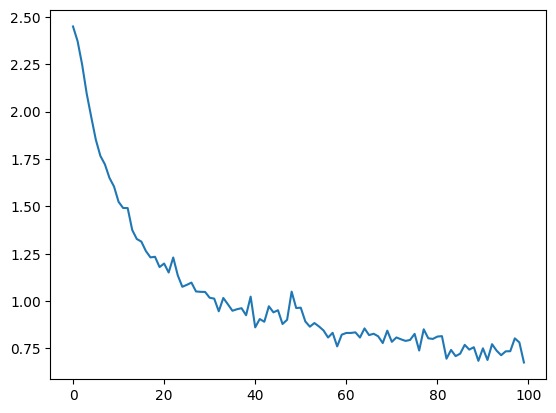

In [11]:
all_losses = []

for i in range(n_iters):
    category, line, category_tensor, line_tensor = random_training_example(category_lines, all_categories)

    output, loss = train(line_tensor, category_tensor)
    current_loss += loss

    # if (i+1)%5000 == 0:
    #   print(i+1, loss)

    if (i+1) % plot_steps == 0:
        all_losses.append(current_loss / plot_steps)
        current_loss = 0

    if (i+1) % print_steps == 0 or i==0:
        guess = category_from_output(output)
        correct = "CORRECT" if guess == category else f"WRONG ({category})"
        print(f"{i+1} {(i+1)/n_iters*100} {loss:.4f} {line} / {guess} {correct}")


plt.figure()
plt.plot(all_losses)
plt.show()

In [52]:
pred, y_test = [], []

with torch.no_grad():
  for i in tqdm(range(10_000)):
    category, line, category_tensor, line_tensor = random_training_example(category_lines, all_categories)

    hidden = rnn.init_hidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    guess = category_from_output(output)

    pred.append(guess), y_test.append(category) 
    # print(line, guess, guess == category)

100%|██████████| 10000/10000 [00:14<00:00, 707.07it/s]


In [54]:
accuracy_score(y_test, pred)

0.7767